In [1]:
"""
Victor van der Wel
"""
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from scipy.optimize import minimize,Bounds, LinearConstraint
from numba import jit
from scipy.stats import multivariate_t
import math

#### generate data

In [2]:
NUMBA_CAPTURED_ERRORS='new_style'

Three innovations to the specification.


1.   Allow for a vector of time-varying correlations.
2.   Do not force the spatial correlations to remain in the $[0,1]$ interval.
3.   Time-varying step lengths for the scaled score steps to ensure the spatial stability of the model at all times.


It is important to allow for both heterogeneity and time-variation:
*   If the dynamics are omitted, differences over time in network fragility are not captured well.
*   If heterogeneity is omitted, a scalar dynamic spatial parameter only provides a very blurred picture of the different positions of the network players over time.


Generate data by simulating

\begin{align}
\mathbf{y}_t = (\mathbb{I}_N-\mathbf{R}_t\mathbf{W}_t)^{-1}\mathbf{X}_t\mathbf{\beta} + (\mathbb{I}_N-\mathbf{R}_t\mathbf{W}_t)^{-1}\mathbf{ɛ}_t,
\end{align}

In [3]:
@jit(nopython=True)
def generate_W_matrix(iN):
    # Generate a random matrix that contains the spatial weights
    # the rows sum to 1

    iW =np.random.rand(iN, iN)
    iW /= iW.sum(axis=1)[:, np.newaxis]

    return iW

@jit(nopython=True)
def generatate_R_values(iT):
    #generate time-varying spatial spillovers

    R1 = 0.3+0.4*np.cos(2*np.pi*np.linspace(0,iT, num=iT)/iT)
    R2 = 0.3+0.4*np.sin(2*np.pi*np.linspace(0,iT, num=iT)/iT)
    R3 = 0.3+0.4*np.cos(4*np.pi*np.linspace(0,iT, num=iT)/iT)

    return R1,R2,R3

In [4]:
def fGenerateSAR(iT,iN,iK,iNu,iBeta,iStDev):
    X = np.random.randn(iT*iN, iK)

    Y = np.zeros((iT, iN))
    iW =generate_W_matrix(iN)
    R = generatate_R_values(iT)
    Rmat = np.vstack([[R[j] for i in range(int(iN/3))] for j in range(3)])
    Cm = np.repeat(np.array([i for i in range(3)]),int(iN/3))
    for t in range(iT):
      iR = np.diagflat(Rmat[:,t])

      #np.random.seed(t) # make sure to have the same random values

      value = np.linalg.inv(np.eye(iN)-np.dot(iR,iW)) @(X[t*iN:(t+1)*iN] *iBeta) + np.linalg.inv(np.eye(iN)-np.dot(iR,iW)) @((multivariate_t.rvs(np.zeros(iN), np.eye(iN) * iStDev, df=iNu, size=1).reshape(-1,1)))

      Y[t] = value.T[0]

    #return data, the spatial weights matrix, regressors and spatial spillovers matrix
    return (Y,iW,X,Cm,Rmat.T)


\begin{align}
&\mathbf{y}_t = \mathbf{R}_t\mathbf{W}_t\mathbf{y}_t + \mathbf{ɛ}_t, \quad\quad \mathbf{ɛ}_t\overset{i.i.d.}{\sim} p_{\epsilon}(\mathbf{ɛ}_t;\Sigma,v)\\
&\mathbf{f}_t = \text{diag}(\mathbf{R}_t) = (\mathbf{R}_{1,1,t},\dots, \mathbf{R}_{N,N,t})^T\\
&\mathbf{f}_{t+1} = \mathbf{\omega} + \mathbf{B}_t\mathbf{f}_t + \mathbf{A}_t\mathbf{s}_t\\
\\&\text{where}\\
\\
&\mathbf{s}_t = |\mathbf{Z}_t| \cdot w_t \cdot \text{diag}(\mathbf{\Sigma}^{-1}\mathbf{e}_ty_t^{*T}) - \text{diag}(\mathbf{W}_t\mathbf{Z}_t^{*}),\\[1em]
&y_t^{*} = \mathbf{W}_t\mathbf{y}_t\\[1em]
&\mathbf{e}_t = \mathbf{y}_t-\mathbf{R}_t\mathbf{W}_t\mathbf{y}_t,\\[1em]
&\mathbf{Z}_t = \mathbf{I}_N-\mathbf{R}_t\mathbf{W}_t,\\[1em]
& \mathbf{Z}_t^{*}=|\mathbf{Z}_t|\mathbf{Z}_t^{-1}
\end{align}



#### Make selection matrix based on cluster memberships

In [5]:
@jit(nopython=True)
def makeHtmatrix(dim):
  matrix = np.zeros((dim, 3))
  for i in range(3):
    matrix[i*int(dim/3):(i+1)*int(dim/3), i] = 1
  return matrix

In [6]:
@jit(nopython=True)
def fMakeHtmatrixCluster(iN1,iN2,iN3):
  matrix = np.zeros((int(iN1+iN2+iN3), 3))

  matrix[:iN1, 0] = 1
  matrix[iN1:iN1+iN2, 1] = 1
  matrix[iN1+iN2:, 2] = 1
  return matrix

In [7]:
@jit(nopython=True)
def prelim(vData):
    iT,iN= vData.shape
    CovMatrix = np.diagflat(np.array([np.var(vData.T[i]) for i in range(iN)]))
    vFt = np.zeros((iT,3))
    vLikelihoodValues = np.zeros(iT)
    return iT,iN,CovMatrix,vFt,vLikelihoodValues

#### Filter

In [25]:
@jit(nopython=True)
def fFilterSAR(Y,params):
    """
    Input: Y,params
    Y contains:           (observables)
    - vData: (float)    a TxN matrix with observations
    - iW:    (float)    a NxN matrix with spatial weights
    - X:     (float)    a matrix of regressors
    - Cm:    (int)      a N vector of cluster memberships
    - R:     (float)    a Txk matrix of spatial spillovers

    params contains:      (optimised by maximum likelihood estimation)
    - iB     (float)    a scalar variable
    - iVt_int(float)    a scalar variable
    - omega1,2,3 (float)a scalar variable for the updating equation

    returns
    the filtered spatial spillovers and the log-likelihood contributions
    """
    vData, iW, X,Cm, R = Y
    iB, iVt_int, omega1, omega2, omega3 = params
    iNu = 5
    g=3

    MinlenCluster =1
    iT,iN,CovMatrix,vFt,vLikelihoodValues = prelim(vData)

    def LOCAL_MakeHtmat(Cm,iN,g):
      matrix = np.zeros((iN, g),dtype=np.float64)
      k=0
      for i in range(g):
        matrix[k:k+sum(Cm==i), i] = 1
        k+=sum(Cm==i)
      return matrix

    Ht=LOCAL_MakeHtmat(Cm,iN,g)

    def validate_cluster_membership(Cm,Ht,g):
      if min(np.sum(Ht,axis=1)) <MinlenCluster:
          print("*** !!an invalid clustermembership value was encountered!! ***")
          return False
      else:
        for value in Cm:
          if value != np.int64(value):
            print("*** !!a non-integer clustermembership value was encountered!! ***")
            return False
          elif value < 0 or value >= g:
            print("*** !!an invalid clustermembership value was encountered!! ***")
            return False
      return True

    if not validate_cluster_membership(Cm,Ht,g):
      pass

    iFt= np.array([omega1, omega2, omega3])

    iBeta = np.zeros(g)                             #for now we only use beta=0
    B = np.eye(g) * iB
    A = np.eye(g) * iVt_int

    dOmega= np.array([omega1, omega2, omega3]).reshape(-1,1)
    wtop = (1+ (iN+2)/(iNu-2))
    for i1 in range(iT):
      vFt[i1] = iFt

      iR = np.diagflat(Ht@vFt[i1].reshape(-1,1))      #vanwege numba kunnen we niet iFt.T gebruiken maar alleen vFt[i].T

      yt=vData[i1].reshape(-1,1)
      Ystar = np.dot(iW,yt).reshape(-1,1)

      #scaling paramter that controls spatial stability
      Zt = np.eye(iN)-np.dot(iR,iW)
      Zt_star = np.linalg.det(Zt)*np.linalg.inv(Zt)
      logdetZt = np.linalg.slogdet(Zt)[1]

      #calculate residuals
      e_t= yt-np.dot(iR,iW)@yt #-np.dot(X[i1*iN:(i1+1)*iN],iBeta).reshape(-1,1)
      et_cov= (1/np.diag(CovMatrix)@e_t**2)[0]

      #stack likelihood contributions
      autoCov = (1+ et_cov/(iNu-2)) #(e_t/np.diag(CovMatrix)))[0]/(iNu-2)) #
      vLikelihoodValues[i1] =  logdetZt- 0.5 * (iNu + iN) * np.log(autoCov)

      # if the eigenvalue of R_tW_t >1 in absolute value then adjust the stepsize to zero
      bin = 0 if max(np.abs(np.linalg.eigh(np.dot(iR,iW))[0]))>=1 else 1

      #calculate updating step
      w_t = wtop/ autoCov
      s_t = np.exp(logdetZt) * Ht.T@ (w_t * (1 / np.diag(CovMatrix)) * np.dot(e_t, Ystar.T) - np.sum(iW * Zt_star.T, axis=1).reshape(-1, 1) )

      value = (np.eye(g)-B) @ dOmega + B @ vFt[i1].reshape(-1,1)+ A @ s_t *bin
      iFt = value.T[0]                    #omdat numba niet goed werkt transpose
    vLikelihoodValues += math.lgamma((iNu + iN) / 2) - math.lgamma(iNu / 2)- 0.5*iN*np.log(iNu-2) - 0.5 *iN* np.log(np.pi)-0.5*np.linalg.slogdet(CovMatrix)[1]

    return (vFt,vLikelihoodValues)

In [9]:
x1= fGenerateSAR(1000,3,1,5,np.zeros(1),0.01)

In [28]:
k=fFilterSAR(x1,(0.9821806,   0.03315694,  0.02437193,  0.63309392, -0.06294334))

In [ ]:
k

#### Clustering algorithm

In [ ]:
def fClusteringAlgorithm():


#### Support functions

In [31]:
###########################################################
### vh= _gh_stepsize(vP)
@jit(nopython=True)
def _gh_stepsize(vP):
    """
    Purpose:
        Calculate stepsize close (but not too close) to machine precision

    Inputs:
        vP      1D array of parameters

    Return value:
        vh      1D array of step sizes
    """

    vh = 1e-8*(np.fabs(vP)+1e-8)   # Find stepsize
    vh = np.maximum(vh, 5e-6)      # Don't go too small

    return vh

In [32]:
###########################################################
### vG= gradient_2sided(fun, vP, *args)
@jit(nopython=True)
def gradient_2sided(fun, vP, *args):
    """
    Purpose:
        Compute numerical gradient, using a 2-sided numerical difference
        Author:Charles Bos, following Kevin Sheppard's hessian_2sided, with
        ideas/constants from Jurgen Doornik's Num1Derivative

    Inputs:
        fun     function, as used for minimize()
        vP      1D array of size iP of optimal parameters
        args    (optional) extra arguments

    Return value:
        vG      iP vector with gradient

    See also:
        scipy.optimize.approx_fprime, for forward difference
    """

    iP   =  np.size(vP)
    vP   =  vP.reshape(iP)      # Ensure vP is 1D-array

    #  f  = fun(vP, *args)      # central function value is not needed
    vh= _gh_stepsize(vP)
    mh   =  np.diag(vh)         # Build a  diagonal matrix out of h

    fp = np.zeros(iP)
    fm = np.zeros(iP)
    for i in range(iP):         # Find f(x+h), f(x-h)
        fp[i] =  fun(vP+mh[i], *args)
        fm[i] =  fun(vP-mh[i], *args)

    vhr = (vP +  vh) - vP       # Check for effective stepsize right
    vhl = vP - (vP - vh)        # Check for effective stepsize left
    vG= (fp -  fm) /  (vhr +  vhl)  # Get central gradient

    return vG

In [33]:
###########################################################
### mG= jacobian_2sided(fun, vP, *args)

def jacobian_2sided(fun, vP, *args):
    """
    Purpose:
        Compute numerical jacobian, using a 2-sided numerical difference

    Author:
        Charles Bos, following Kevin Sheppard's hessian_2sided, with
        ideas/constants from Jurgen Doornik's Num1Derivative

    Inputs:
        fun     function, return 1D array of size iN
        vP      1D array of size iP of optimal parameters
        args    (optional) extra arguments

    Return value:
        mG      iN x  iP   matrix with jacobian

    See also:numdifftools.Jacobian(), for similar output
    """
    iP = np.size(vP)
    vP = vP.reshape(iP)        # Ensure vP is 1D-array
    vF = fun(vP, *args)        # evaluate function, only to get size
    iN = vF.size
    vh= _gh_stepsize(vP)
    mh   =  np.diagflat(vh)        # Build a  diagonal matrix out of h
    mGp = np.zeros((iN, iP))
    mGm = np.zeros((iN, iP))
    for i in   range(iP):     # Find f(x+h), f(x-h)
        mGp[:,i] =  fun(vP+mh[i], *args)
        mGm[:,i] =  fun(vP-mh[i], *args)
    vhr = (vP +  vh) - vP    # Check for effective stepsize right
    vhl = vP   -  (vP -  vh)    # Check for effective stepsize left
    mG= (mGp -  mGm) / (vhr +  vhl)  # Get central jacobian
    return mG

In [34]:
###########################################################
### mH= hessian_2sided(fun, vP, *args)

def hessian_2sided(fun, vP, *args):
    """
    Purpose:
        Compute numerical hessian, using a  2-sided numerical difference

    Author:Kevin Sheppard, adapted by Charles Bos

    Source:https://www.kevinsheppard.com/Python_for_Econometrics

    Inputs:
        fun     function, as used for minimize()
        vP      1D array of size iP of optimal parameters
        args    (optional) extra arguments

    Return value:
        mH      iP x  iP matrix with symmetric hessian
    """
    iP = np.size(vP,0)
    vP= vP.reshape(iP)    # Ensure vP is 1D-array
    f = fun(vP, *args)
    vh= _gh_stepsize(vP)
    vPh = vP + vh
    vh = vPh - vP

    mh = np.diag(vh)      # Build a  diagonal matrix out of vh

    fp   =  np.zeros(iP)
    fm   =  np.zeros(iP)
    for i in range(iP):
        fp[i] =  fun(vP+mh[i], *args)
        fm[i] =  fun(vP-mh[i], *args)

    fpp = np.zeros((iP,iP))
    fmm = np.zeros((iP,iP))
    for i in   range(iP):
        for j in   range(i,iP):
            fpp[i,j] =  fun(vP +  mh[i] +  mh[j], *args)
            fpp[j,i] =  fpp[i,j]
            fmm[i,j] =  fun(vP -  mh[i] -  mh[j], *args)
            fmm[j,i] =  fmm[i,j]

    vh   =  vh.reshape((iP,1))
    mhh = vh   @  vh.T             # mhh= h  h', outer product of h-vector

    mH   =  np.zeros((iP,iP))
    for i in range(iP):
        for j in range(i,iP):
            mH[i,j] =  (fpp[i,j] -  fp[i] - fp[j] +  f  +  f  - fm[i] -  fm[j] + fmm[i,j])/mhh[i,j]/2
            mH[j,i] =  mH[i,j]

    return mH

#### optimisation class

In [47]:
class SAROptimization:
    def __init__(self, Y):
        self.Y = Y
        self.vData, self.iW, self.X, self.Cm, self.R = Y
        self.x0 = []
        self.likelihoodvalue = []
        self.updatedCm = []
        self.covariancematrix = []
        self.filter = []
        self.success = False
        self.vTheta = [0.9, 0.07, 0.7, 0.3, 0.7]   ###initial guess
        self.fMaximize_likelihood_sar()

    def LOCAL_fParameterTransform(self, vTheta, bShapeAsVector=False):
        r = (vTheta[0], vTheta[1], vTheta[2], vTheta[3], vTheta[4])
        if (bShapeAsVector == True):
            return np.append([], r)
        else:
            return r

    def LOCAL_fObjective(self,vTheta, bForAllT=False):
        vFt, vLikelihoodValues = fFilterSAR(self.Y, vTheta)
        self.filter = vFt
        if (bForAllT == True):
            return vLikelihoodValues
        else:
            return -np.mean(vLikelihoodValues)


    def LOCAL_fComputeCovarianceMatrix(self):
        mH = hessian_2sided(self.LOCAL_fObjective, self.vTheta)
        mCov = np.linalg.inv(mH)
        mCov = (mCov + mCov.T) / 2  # Force to be symmetric

        mG = jacobian_2sided(self.LOCAL_fObjective, self.vTheta, True)
        mG = np.dot(mG.T, mG) / self.vData.shape[0]
        mG = np.dot(mG, mCov)
        mCov = np.dot(mCov, mG) / self.vData.shape[0]
        return mCov

    def LOCAL_fLikelihoodPosition(self):
        Cm_star = self.Cm.copy()
        vVals = np.unique(self.Cm)
        vLikelihoods = np.zeros((len(self.Cm), len(vVals)), dtype=np.float64)

        for j in range(len(Cm_star)):       #optimise the cluster memberships one company at the time based on maximum likelihood
                                            #after each iteration the position of the maximum likelihood is the new membership
            for i, value in enumerate(np.unique(self.Cm)):
                Cm_star[j] = value
                Y = (self.vData, self.iW, self.X, Cm_star, self.R)
                val, vLikelihoodValues = fFilterSAR(Y, self.vTheta)
                vLikelihoods[j][i] = -np.mean(vLikelihoodValues)
            Cm_star[j] = np.argmin(vLikelihoods[j])#self.Cm.copy()
        self.updatedCm = Cm_star#np.argmin(vLikelihoods, axis=1)

    def fMaximize_likelihood_sar(self):
        self.x0 = self.vTheta

        tSol = minimize(self.LOCAL_fObjective, self.vTheta, method='L-BFGS-B', bounds=[(0, 1), (0, 1), (-.2, 1), (-.2, 1), (-.2, 1)], options={'disp': True, 'maxiter': 250, 'ftol': 1e-15, 'gtol': 1e-15})

        self.success = tSol['success']
        if not tSol['success']:
            print("*** no true convergence: ", tSol['message'])
        else:
            self.vTheta = tSol['x']
            self.likelihoodvalue = -self.vData.shape[0] * tSol['fun']
            self.covariancematrix = self.LOCAL_fComputeCovarianceMatrix()


In [42]:
x1[-2]#[0]=2

array([2, 0, 1, 1, 2, 2])

In [48]:
x1= fGenerateSAR(1000,6,1,5,np.zeros(1),0.01)
Optimised = SAROptimization(x1)
Optimised.LOCAL_fLikelihoodPosition()

The ML parameter values are:
 [0.98398882 0.03955822 0.06968198 0.073255   0.01443113]

The corresponding covariancematrix is: 
[[ 1.03053085e-05 -8.19533283e-06 -8.62952957e-05 -8.24895692e-05
  -3.31281238e-05]
 [-8.19533283e-06  3.52414925e-05 -1.36667804e-04 -9.80426315e-05
  -2.55886420e-05]
 [-8.62952957e-05 -1.36667804e-04  8.07098326e-03  1.34321284e-03
   1.67872145e-04]
 [-8.24895692e-05 -9.80426315e-05  1.34321284e-03  6.54152254e-03
  -7.76956929e-04]
 [-3.31281238e-05 -2.55886420e-05  1.67872145e-04 -7.76956929e-04
   4.96331806e-03]]

The updated vector of cluster memberships is:
 [0 0 1 1 2 2]



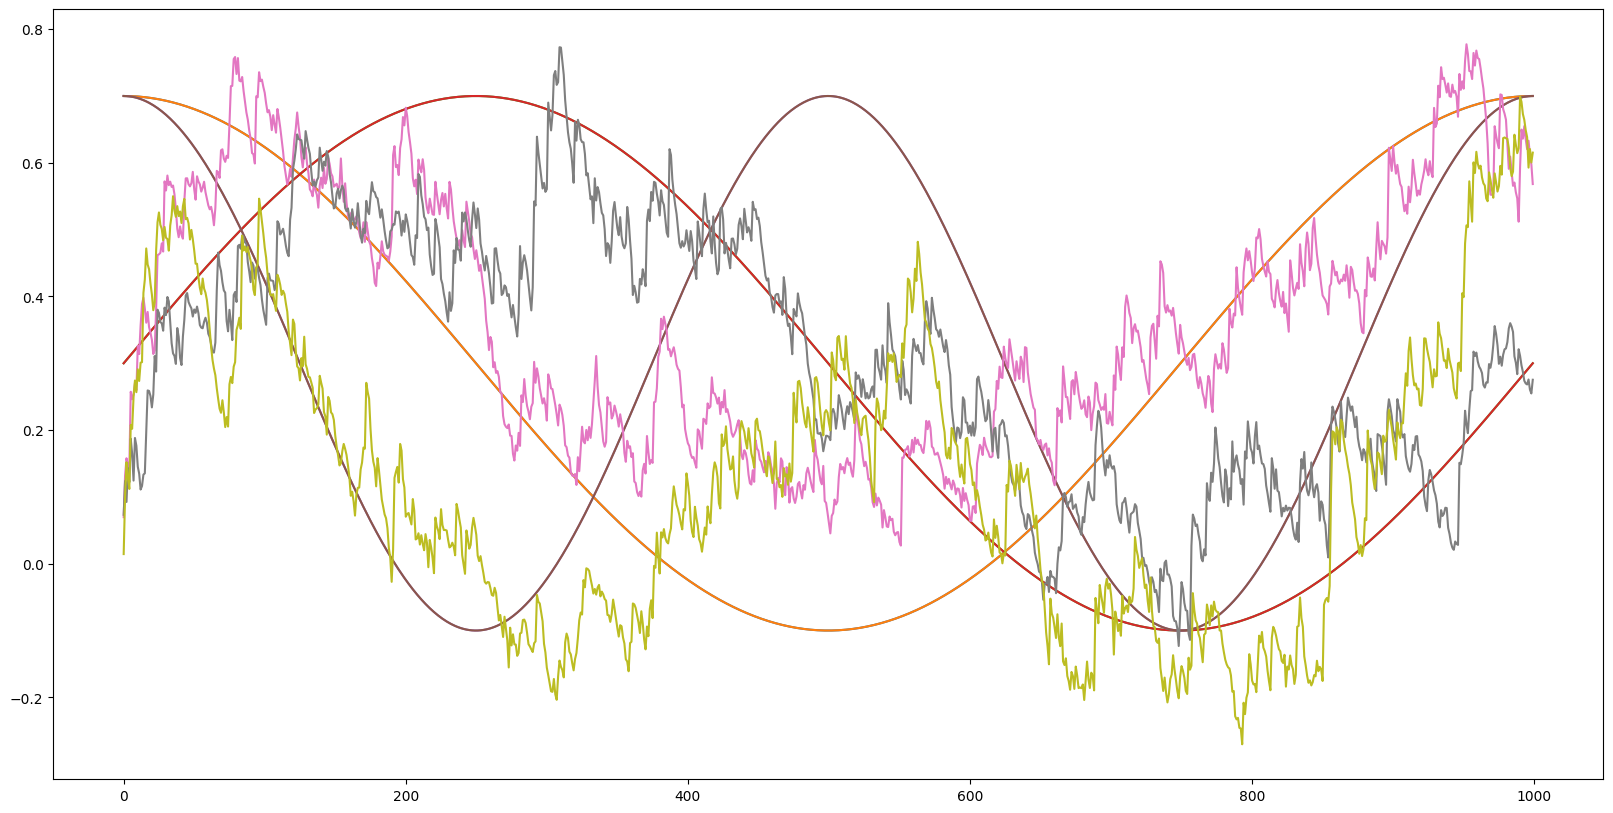

In [46]:
print(f'The ML parameter values are:\n {Optimised.vTheta}\n')
print(f'The corresponding covariancematrix is: \n{Optimised.covariancematrix}\n')

print(f'The updated vector of cluster memberships is:\n {Optimised.updatedCm}\n')
plt.figure(figsize=(20,10))
plt.plot(x1[-1])
plt.plot(Optimised.filter)
plt.show()

#### optimisation

In [ ]:
class cMaximizeLikelihoodSAR:
    def __init__(self):
        self.x0 = []
        self.x = []
        self.likelihoodvalue = []
        self.Cm=[]
        self.updatedCm = []
        self.covariancematrix = []
        self.filter = []
        self.success = False

In [ ]:
def fSARml(Y):
    cReturnValue = cMaximizeLikelihoodSAR()

    def LOCAL_fParameterTransform(vTheta, bShapeAsVector=False):
        r = ((vTheta[0]),(vTheta[1]),(vTheta[2]),(vTheta[3]),(vTheta[4]))
        #r = ((vTheta[0]),(vTheta[1]))
        if (bShapeAsVector == True):
            return np.append([], r)
        else:
            return r


    def LOCAL_fObjective(vTheta, bForAllT=False):
        # run the filter
        vFt, vLikelihoodValues = fFilterSAR(Y,vTheta)
        cReturnValue.filter = vFt
        if (bForAllT == True):
            return  vLikelihoodValues
        else:
            return  -np.mean(vLikelihoodValues)


    def LOCAL_fComputeCovarianceMatrix(vTheta):
        # compute the inverse hessian of the average log likelihood

        mH= hessian_2sided(LOCAL_fObjective, vTheta)
        mCov = np.linalg.inv(mH)
        mCov = (mCov +  mCov.T)/2       #  Force to be symmetric

        # compute the outer product of gradients of the average log likelihood
        mG = jacobian_2sided(LOCAL_fObjective, vTheta, True)
        mG = np.dot(mG.T, mG) / vData.shape[0]
        mG = np.dot(mG, mCov)
        mCov = np.dot(mCov, mG) / vData.shape[0]
        return mCov

    def LOCAL_fLikelihoodPosition(vTheta,Cm):
      Cm_star=Cm.copy()
      vVals= np.unique(Cm_star)
      vLikelihoods=np.zeros((len(Cm),len(vVals)), dtype=np.float64)
      for j in range(len(Cm)):
        for i, value in enumerate(np.unique(Cm)):
          Cm_star[j]=value
          Y = (vData,iW,X,Cm_star,R)
          val,vLikelihoodValues = fFilterSAR(Y,vTheta)
          vLikelihoods[j][i]= -np.mean(vLikelihoodValues)
        Cm_star=Cm.copy()
      return np.argmin(vLikelihoods,axis=1)


    # initialize starting values and return value
    vData,iW,X,Cm,R = Y
    vTheta = [0.9, 0.07,0.7, 0.3, 0.7]
    #vTheta = [0.9, 0.07]
    cReturnValue.x0 = vTheta
    cReturnValue.Cm=Cm


    # Run the optimization
    tSol = minimize(LOCAL_fObjective, vTheta, method='L-BFGS-B', bounds=[(0, 1), (0, 1),(-.2,1),(-.2,1),(-.2,1)],options={'disp': True, 'maxiter': 250, 'ftol': 1e-15, 'gtol': 1e-15})

    cReturnValue.success = tSol['success']
    # check for success and store results

    if (tSol['success'] != True):
        print("*** no true convergence: ",tSol['message'])
    else:
        cReturnValue.x = tSol['x']
        cReturnValue.likelihoodvalue = -vData.shape[0] * tSol['fun']
        cReturnValue.covariancematrix = LOCAL_fComputeCovarianceMatrix(cReturnValue.x)
        cReturnValue.updatedCm = LOCAL_fLikelihoodPosition(cReturnValue.x,Cm)
        mJ = jacobian_2sided(LOCAL_fParameterTransform, cReturnValue.x, True)

    return cReturnValue

[[66.89009346 52.86541427 -1.5325563  -3.30011574 -0.34204195]
 [52.86541427 41.57566291 -1.17018839 -2.29817498 -0.34727332]
 [-1.5325563  -1.17018839  0.50726978  0.2425482   0.21641355]
 [-3.30011574 -2.29817498  0.2425482   0.3983347   0.16759039]
 [-0.34204195 -0.34727332  0.21641355  0.16759039  0.56242122]]
[ 0.96243802  0.05980902 -0.05740589  0.5181136   0.09643383]
[[ 0.0083355  -0.00988372 -0.00318209  0.01582224 -0.00459635]
 [-0.00988372  0.01175806  0.00377984 -0.01853612  0.00539092]
 [-0.00318209  0.00377984  0.00395075 -0.00726335  0.00128928]
 [ 0.01582224 -0.01853612 -0.00726335  0.03426614 -0.00948206]
 [-0.00459635  0.00539092  0.00128928 -0.00948206  0.00470711]]
[0 1 2]



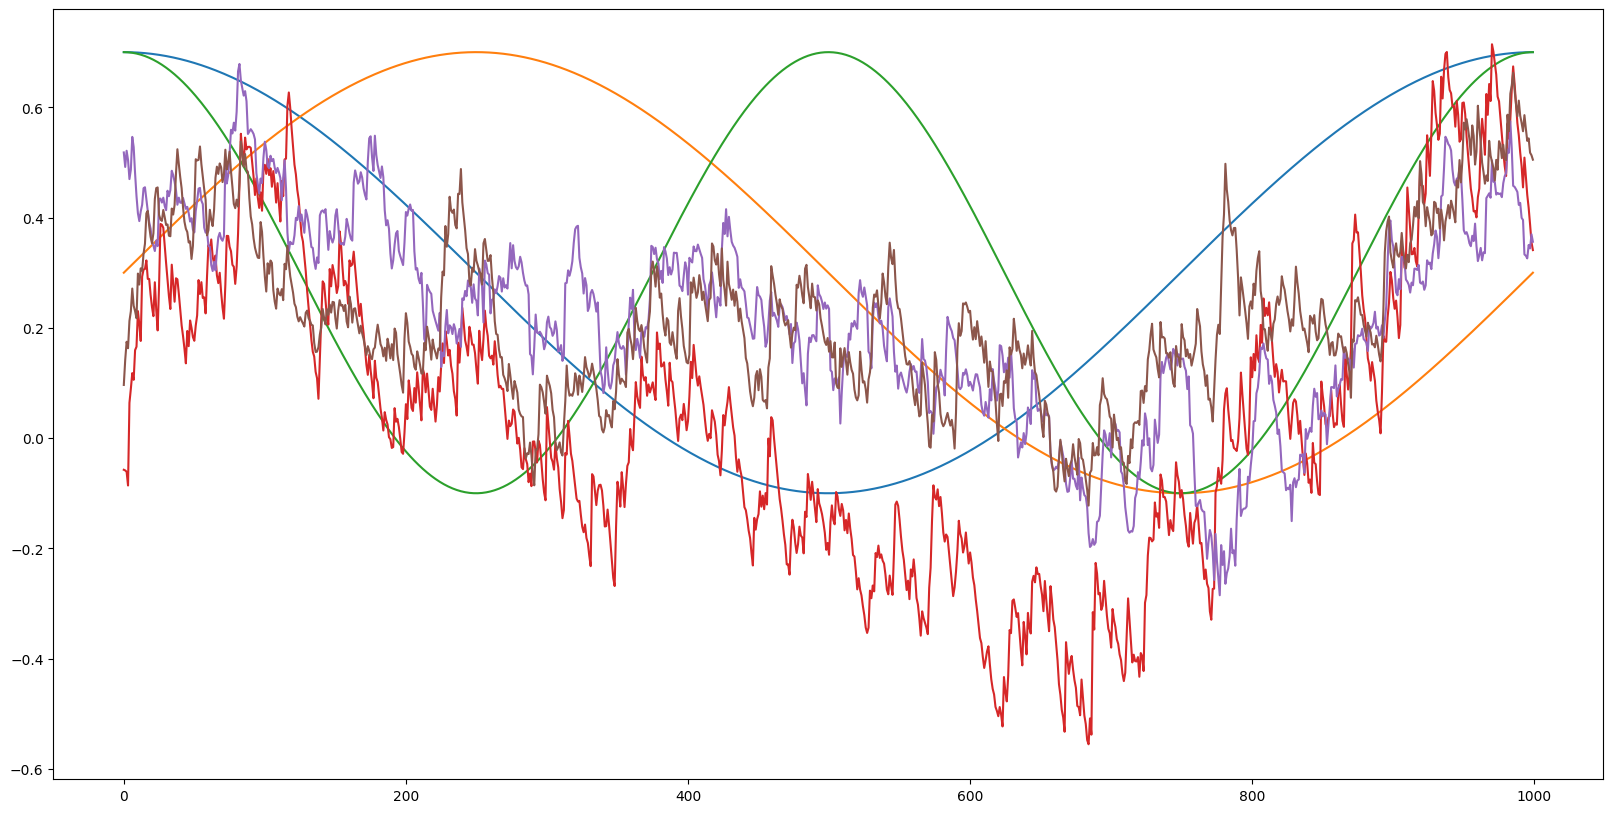

In [ ]:
"""
Neem N als veelvoud van 3 voor eenvoudige berekeningen
Time tracking:
number of params =5
N       time

3       00min 08sec
6       00min 18sec
9       00min 25sec
12      00min 36sec
18      01min 06sec
24      02min 16sec
30      02min 54sec
45      06min 40sec
99      25min 10sec
Time tracking:
number of params =2
N       time

3       00min 02sec
6       00min 04sec
9       00min 12sec
12      00min 12sec
18      00min 31sec
24      00min 53sec
30
45
"""


x1= fGenerateSAR(1000,3,1,5,np.zeros(1),0.01)
y = fSARml(x1)
print(y.x)
print(y.covariancematrix)
print(y.updatedCm)
print("")

plt.figure(figsize=(20,10))
plt.plot(x1[-1])
plt.plot(y.filter)
plt.show()

In [ ]:
def MonteCarlo():
  R1= np.zeros((100,1000))
  R2= np.zeros((100,1000))
  R3= np.zeros((100,1000))
  for i in range(100):
    x1= fGenerateSAR(1000,3,1,5,np.zeros(1),0.01)
    val = fSARml(x1)
    R1[i] = val.filter.T[0]
    R2[i] = val.filter.T[1]
    R3[i] = val.filter.T[2]
  return R1,R2,R3

In [ ]:
tester = MonteCarlo()

*** no true convergence:  ABNORMAL_TERMINATION_IN_LNSRCH
*** no true convergence:  ABNORMAL_TERMINATION_IN_LNSRCH
*** no true convergence:  ABNORMAL_TERMINATION_IN_LNSRCH
*** no true convergence:  ABNORMAL_TERMINATION_IN_LNSRCH
*** no true convergence:  ABNORMAL_TERMINATION_IN_LNSRCH
*** no true convergence:  ABNORMAL_TERMINATION_IN_LNSRCH
*** no true convergence:  ABNORMAL_TERMINATION_IN_LNSRCH
*** no true convergence:  ABNORMAL_TERMINATION_IN_LNSRCH
*** no true convergence:  ABNORMAL_TERMINATION_IN_LNSRCH


LinAlgError: Matrix is singular to machine precision.

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(x1[-1])
plt.plot(np.mean(tester[0].T,axis=1))
plt.plot(np.mean(tester[1].T,axis=1))
plt.plot(np.mean(tester[2].T,axis=1))


In [ ]:
tester.T